<a href="https://colab.research.google.com/github/Amkic/sp500-nbeats-forecasting/blob/main/nbeats_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Forecasting using n-beats from Dart


In this project, we aim to predict a stock market using n-beats method.

The goal is to predict future stock prices over a short horizon (e.g the next 5 days) based on historical data and identify which architecture performs bet for this type of financial time series.

This project combines Deep learning, time series analysis and financial modeling. The results will be shared and visualized step-by-step in this notebook.

In [ ]:
#First we need to install darts and other libraries
!pip install darts

In [ ]:
!pip install pytorch_lightning

In [ ]:
%matplotlib inline
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Downlaod S&P500 data from 01/01/2020 to 14/07/2025
data = yf.download('^GSPC', start='2020-01-01', end='2025-07-14')
data.columns = data.columns.droplevel(1)

/tmp/ipython-input-201-1835088645.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('^GSPC', start='2020-01-01', end='2025-07-14')
[*********************100%***********************]  1 of 1 completed


Since the stock market is closed on weekends and some holidays, the data contains gaps that can affect the learning of neural networks. To adress this, we smooth the data using 5-Day moving avergage. This helps to eliminate noise and discontinuities, allowing the model to better capture the underlying trends. The resulting denoised series will be used to train our forecasting models.

In [ ]:
#Function for denoising the data and remove empty data
def treatedData(data):

  #take the data as the index
  if not isinstance(data.index, pd.DatetimeIndex):
    if 'Date' in data.columns:
      data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
      data.set_index('Date', inplace=True)
    else:
      raise ValueError("DataFrame muse have a datetime index or Date")

  df = data.copy()
  df.index = pd.to_datetime(df.index).tz_localize(None)
  df.dropna(subset=['Close'], inplace=True)

  # Treating the discontinuities
  business_days = pd.bdate_range(start=df.index.min(), end=df.index.max())
  df = df.reindex(business_days)

  df['Close'] = df['Close'].fillna(method='ffill')

  # 5 day Moving average
  df['Close_denoised'] = df['Close'].rolling(window=5).mean()

  fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

  axs[0].plot(df.index, df['Close'], label='Original Close')
  axs[0].plot(df.index, df['Close_denoised'], label='Denoised Close (5-day MA)')
  axs[0].set_title("Original vs Denoised Close Prices")
  axs[0].legend()
  axs[0].grid()

  axs[1].plot(df.index, df['Close'], color='red', label='Original Close')
  axs[1].set_title("Original Close Price")
  axs[1].legend()
  axs[1].grid()

  axs[2].plot(df.index, df['Close_denoised'], color='green', label='Denoised Close (5-day MA)')
  axs[2].set_title("Denoised Close Price")
  axs[2].legend()
  axs[2].grid()

  plt.tight_layout()
  plt.show()

  return df.reset_index().rename(columns={"index": "Date"})

/tmp/ipython-input-202-2487231852.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'] = df['Close'].fillna(method='ffill')


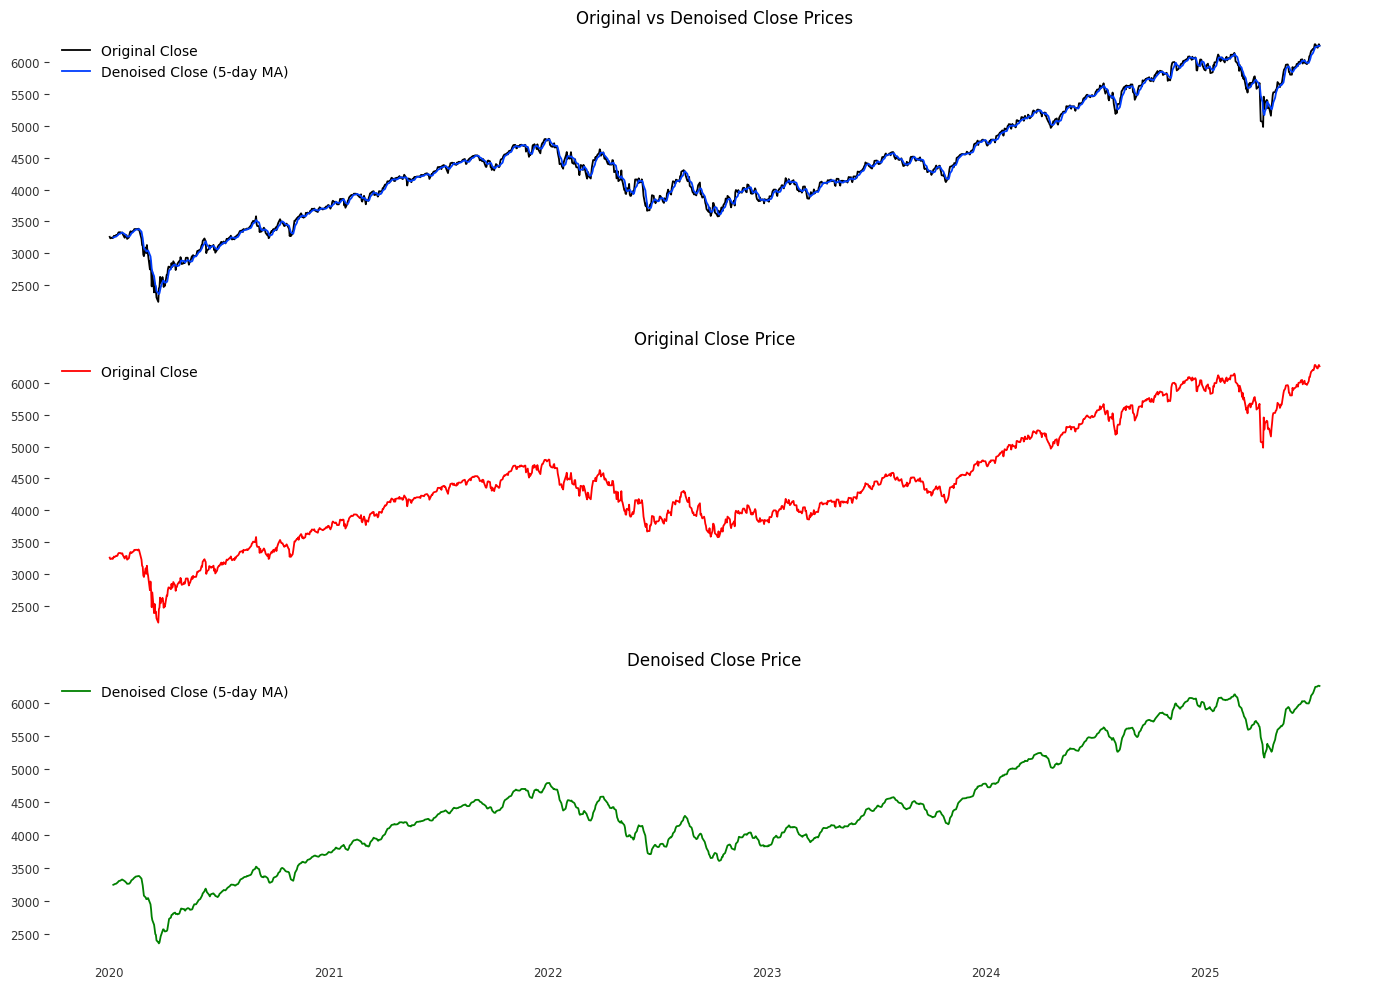

In [ ]:
#Print of the Original and denoised Close prices
df = treatedData(data)

#Deleting the 5 first rows thats are empty because of the 5 day moving average
df = df.dropna(subset=['Close_denoised']).copy()

Constants

In [ ]:
SEQ_LENGTH = 100
RANDOM_STATE = 0
FULL_TRAINING = False

This section defines the training configuration and hyperparameters for our time series forecasting model using Pythorch Lightning and the Darts Library.

**Early stopping**: Stops training if the validation loss doesn't improve after several epochs (patience of 10), helping to prevent overfitting.

**Optimizer and Learning Rate Scheduler**: Uses the Adam optimizer with a learning rate of 1e-4 and an exponential decay over epochs to fine-tune the model more effectively.

**Training Mode:** Allows switching between full training (with more data and epochs) or quick testing/debugging mode (limited batches and epochs).

**Progress Bar:** Adds a simple progress bar during training for better visibility.

Loss Function: If a likelihood model like Quantile Regression is used, the model automatically manages the loss; otherwise, it defaults to Mean Squared Error.

**Encoders:** Adds time-related features (hour, day of week, month) to help the model understand temporal patterns.

**Reversible Normalization:** Ensures that the inputs are normalized and denormalized correctly.

**Batch Size and Random Seed:** Controls data batching and ensures reproducibility.

In [ ]:
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.utils.callbacks import TFMProgressBar
from darts.utils.likelihood_models import QuantileRegression

early_stopping_args = {
    "monitor": "val_loss",
    "patience" : 10,
    "min_delta":1e-3,
    "mode" : "min",
}

optimizer_kwargs={
    "lr":1e-4
}

lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {"gamma":0.999}

def create_params(input_chunk_length: int, output_chunk_length: int, full_training=True, likelihood=QuantileRegression()):
  early_stopper = EarlyStopping(**early_stopping_args)

  if full_training:
        limit_train_batches = None
        limit_val_batches = None
        max_epochs = 200
        batch_size = 256
  else:
        limit_train_batches = 20
        limit_val_batches = 10
        max_epochs = 40
        batch_size = 64

  progress_bar = TFMProgressBar(enable_sanity_check_bar=False, enable_validation_bar=False)

  pl_trainer_kwargs = {
        "gradient_clip_val": 1,
        "max_epochs": max_epochs,
        "limit_train_batches": limit_train_batches,
        "limit_val_batches": limit_val_batches,
        "accelerator": "auto",
        "callbacks": [early_stopper, progress_bar],
    }

  if likelihood:
        loss_fn = None
  else:
        loss_fn = torch.nn.MSELoss()

  return {
        "input_chunk_length": input_chunk_length,
        "output_chunk_length": output_chunk_length,
        "use_reversible_instance_norm": True,
        "optimizer_kwargs": optimizer_kwargs,
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": lr_scheduler_kwargs,
        "likelihood": likelihood,
        "loss_fn": loss_fn,
        "save_checkpoints": True,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": RANDOM_STATE,
        "add_encoders": {
            "cyclic": {"future": ["hour", "dayofweek", "month"]}
        },
    }


In [ ]:
import datetime
import pandas as pd
from darts import TimeSeries
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday
from darts.dataprocessing.transformers.scaler import Scaler

Intern functions

Split train, val, test

In [ ]:
def split_train_val_test_darts(series, train_end_date, val_end_date):
    train, temp = series.split_before(pd.Timestamp(train_end_date))
    val, test = temp.split_before(pd.Timestamp(val_end_date))
    return train, val, test

Normalisation

In [ ]:
def normalise_data_darts(data, scaler=None):
    if scaler:
        return scaler.transform(data)
    else:
        scaler = Scaler()
        data = scaler.fit_transform(data)
        return data, scaler

def inverse_normalise_data_darts(data, scaler):
    return scaler.inverse_transform(data)

def normalise_split_data_darts(train, val, test):
    train, scaler = normalise_data_darts(train)
    val = normalise_data_darts(val, scaler)
    test = normalise_data_darts(test, scaler)
    return train, val, test, scaler

Several forecasting methods from the Darts library are available, such as Temporal Convolutional Networks (TCN), Temporal Fusion Transformer (TFT), and others. Here, we focus on the N-BEATS model because it is particularly well-suited for time series forecasting. Its interpretable architecture, strong empirical performance across diverse datasets, and ability to capture complex temporal dynamics without heavy feature engineering make it the most appropriate choice for stock market prediction.

In [ ]:
from darts.models import TCNModel, NBEATSModel, TFTModel, TiDEModel, NHiTSModel, TSMixerModel

TCN

In [ ]:
def get_model_tcn():
    model_tcn = TCNModel(
        model_name="TCN",
        n_epochs=20,
        input_chunk_length=SEQ_LENGTH,
        output_chunk_length=1,
        random_state=RANDOM_STATE,
        dropout=0,
        dilation_base=2,
        weight_norm=True,
        kernel_size=7,
        num_filters=4
    )
    return model_tcn

Deep TCN

In [ ]:
def get_model_deeptcn():
    model_deeptcn = TCNModel(
        model_name="DeepTCN",
        batch_size=32,
        n_epochs=20,
        optimizer_kwargs={"lr": 1e-3},
        random_state=RANDOM_STATE,
        input_chunk_length=SEQ_LENGTH,
        output_chunk_length=1,
        dropout=0.2,
        kernel_size=3,
        num_filters=4,
        save_checkpoints=True,
        force_reset=True,
    )
    return model_deeptcn

N-BEATS

In [ ]:
def get_model_nbeats():
    model_nbeats = NBEATSModel(
        model_name="N-BEATS",
        generic_architecture=True,
        num_stacks=10,
        num_blocks=1,
        num_layers=4,
        layer_widths=512,
        nr_epochs_val_period=1,
        **create_params(SEQ_LENGTH, 1, full_training=FULL_TRAINING)
    )
    return model_nbeats

TFT

In [ ]:
def get_model_tft():
    model_tft = TFTModel(
        model_name="TFT",
        hidden_size=64,
        lstm_layers=1,
        num_attention_heads=4,
        dropout=0.1,
        add_relative_index=True,
        **create_params(SEQ_LENGTH, 1, full_training=FULL_TRAINING)
    )
    return model_tft

TiDE

In [ ]:
def get_model_tide():
    model_tide = TiDEModel(
        model_name="TiDE",
        use_reversible_instance_norm=True,
        **common_model_args
    )
    return model_tide

N-HiTS

In [ ]:
def get_model_nhits():
    model_nhits = NHiTSModel(
        model_name="N-HiTS",
        **create_params(SEQ_LENGTH, 1, full_training=FULL_TRAINING)
    )
    return model_nhits

TSMixer

In [ ]:
def get_model_tsm():
    model_tsm = TSMixerModel(
        model_name="TSMixer",
        **create_params(SEQ_LENGTH, 1, full_training=FULL_TRAINING)
    )
    return model_tsm

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | train_metrics | MetricCollection | 0      | train
1 | val_metrics   | MetricCollection | 0      | train
2 | rin           | RINorm           | 2      | train
3 | stacks        | ModuleList       | 8.9 M  | train
-----------------------------------------------------------
8.9 M     Trainable params
3.2 K     Non-trainable params
8.9 M     Total params
35.458    Total estimated model params size (MB)
134       Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

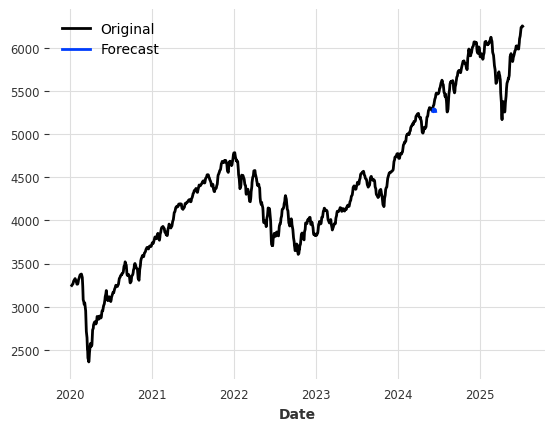

In [ ]:
series = TimeSeries.from_dataframe(df, time_col='Date', value_cols='Close')
series_denoised = TimeSeries.from_dataframe(df, time_col='Date', value_cols ='Close_denoised' )

# Split train/val
train_end = series_denoised.time_index[int(len(series_denoised)*0.8)]
val_end = series_denoised.time_index[-1]

train, val = series_denoised.split_before(train_end)

# training
model = get_model_nbeats()
model.fit(train, val_series=val, verbose=True)

# forecasting on 10 days
forecast = model.predict(n=10)

# plot
series_denoised.plot(label="Original")
forecast.plot(label="Forecast")
forecast_dates = forecast.time_index
series_pred = series_denoised.slice(forecast_dates[0], forecast_dates[-1])

<Axes: xlabel='Date'>

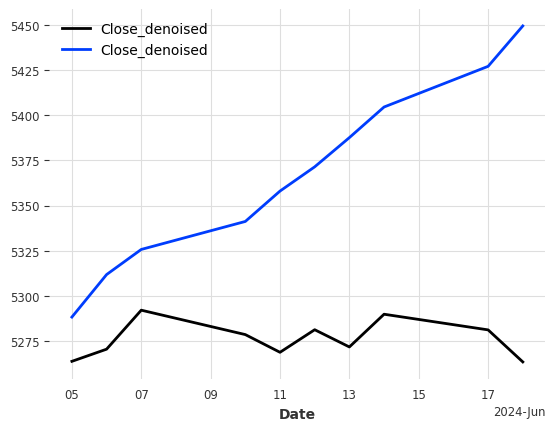

In [ ]:
forecast.plot()
series_pred.plot()

At this step, the model's forecast does not align well with the actual denoised series. While the forecast shows a steady upward trend, the true values exhibit more volatily and a different overall direction.

This mismatch suggest that the model is not capturing the underlying dynamics of the time series correclty.

One possible reason is that we have not yet properly definied a target direction or optimization metric that guides the model toward meaningful forecasting behevior.


In [ ]:
# Functions of https://github.com/gonzalopezgil/xlstm-ts/blob/main/src/ml/models/shared/directional_prediction.py
# Licence MIT - Copyright (c) 2024 Gonzalo López Gil

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def calculate_movement_metrics(true_labels, predicted_labels, model_name, set_type, data_type):
  def calculate_movement_metrics(true_labels, predicted_labels, model_name, set_type, data_type):
    if set_type == "Train":
        # Calculate only accuracy for the training set
        accuracy = accuracy_score(true_labels, predicted_labels) * 100
        print(f'{model_name} ({data_type}) | Train Accuracy: {accuracy:.2f}%')

        return {'Train Accuracy': accuracy}

    if set_type == "Val":
        # Calculate only accuracy for the validation set
        accuracy = accuracy_score(true_labels, predicted_labels) * 100
        print(f'{model_name} ({data_type}) | Validation Accuracy: {accuracy:.2f}%')

        return {'Validation Accuracy': accuracy}

    elif set_type == "Test":
        # Calculate metrics for the test set
        accuracy = accuracy_score(true_labels, predicted_labels) * 100
        recall = recall_score(true_labels, predicted_labels, pos_label=1) * 100
        precision_rise = precision_score(true_labels, predicted_labels, pos_label=1) * 100
        precision_fall = precision_score(true_labels, predicted_labels, pos_label=0) * 100
        f1 = f1_score(true_labels, predicted_labels, pos_label=1) * 100

        print(f'{model_name} ({data_type}) | Test Accuracy: {accuracy:.2f}%')
        print(f'{model_name} ({data_type}) | Recall: {recall:.2f}%')
        print(f'{model_name} ({data_type}) | Precision (Rise): {precision_rise:.2f}%')
        print(f'{model_name} ({data_type}) | Precision (Fall): {precision_fall:.2f}%')
        print(f'{model_name} ({data_type}) | F1 Score: {f1:.2f}%')

        # Confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=["Down", "Up"], yticklabels=["Down", "Up"], cbar=False)

        # Add percentages
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j + 0.5, i + 0.55, f'\n({cm_norm[i, j]:.2%})',
                         horizontalalignment='center',
                         verticalalignment='center',
                         color='black',
                         fontsize=9)

        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{model_name} Confusion Matrix ({data_type} Data)')
        plt.show()

        return {
            'Test Accuracy': accuracy,
            'Recall': recall,
            'Precision (Rise)': precision_rise,
            'Precision (Fall)': precision_fall,
            'F1 Score': f1
        }


def calculate_directions(data):
  directions = np.diff(data.squeeze())
  directional_data = np.zeros((directions.size,2))

  for i, diff in enumerate(directions):
    if diff > 0:
      directional_data[i] = [1, 0]
    elif diff < 0:
      directional_data[i] = [0, 1]

  return directional_data

def evaluate_directional_movement(actual_values_train, backtest_train, actual_values_val, backtest_val, actual_values_test, backtest_test, model_name, data_type, using_darts=True):
    if using_darts:
        train_y = actual_values_train.values()
        train_predictions = backtest_train.values()
        val_y = actual_values_val.values()
        val_predictions = backtest_val.values()
        test_y = actual_values_test.values()
        test_predictions = backtest_test.values()
    else:
        train_y = actual_values_train
        train_predictions = backtest_train
        val_y = actual_values_val
        val_predictions = backtest_val
        test_y = actual_values_test
        test_predictions = backtest_test

    # Calculate directions for training set
    true_directions_train = calculate_directions(train_y)
    predicted_directions_train = calculate_directions(train_predictions)

    # Convert to class labels for training set
    true_labels_train = np.argmax(true_directions_train, axis=1)
    predicted_labels_train = np.argmax(predicted_directions_train, axis=1)

    # Calculate directions for validation set
    true_directions_val = calculate_directions(val_y)
    predicted_directions_val = calculate_directions(val_predictions)

    # Convert to class labels for validation set
    true_labels_val = np.argmax(true_directions_val, axis=1)
    predicted_labels_val = np.argmax(predicted_directions_val, axis=1)

    # Calculate directions for test set
    true_directions_test = calculate_directions(test_y)
    predicted_directions_test = calculate_directions(test_predictions)

    # Convert to class labels for test set
    true_labels_test = np.argmax(true_directions_test, axis=1)
    predicted_labels_test = np.argmax(predicted_directions_test, axis=1)

    # Calculate metrics for training set
    metrics_train = calculate_movement_metrics(true_labels_train, predicted_labels_train, model_name, "Train", data_type)

    # Calculate metrics for validation set
    metrics_val = calculate_movement_metrics(true_labels_val, predicted_labels_val, model_name, "Val", data_type)

    # Calculate metrics for test set
    metrics_test = calculate_movement_metrics(true_labels_test, predicted_labels_test, model_name, "Test", data_type)

    # Combine accuracy into the test metrics dictionary
    metrics_test['Validation Accuracy'] = metrics_val['Validation Accuracy']
    metrics_test['Train Accuracy'] = metrics_train['Train Accuracy']

    return true_labels_test, predicted_labels_test, metrics_test


In [ ]:
#https://github.com/gonzalopezgil/xlstm-ts/blob/main/src/ml/models/shared/directional_prediction.py
## Licence MIT - Copyright (c) 2024 Gonzalo López Gil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# -------------------------------------------------------------------------------------------
# Predict directions
# -------------------------------------------------------------------------------------------

def calculate_directions(data):
    directions = np.diff(data.squeeze())
    directional_data = np.zeros((directions.size, 2))
    for i, diff in enumerate(directions):
        if diff > 0:
            directional_data[i] = [0, 1]  # Up
        else:
            directional_data[i] = [1, 0]  # Down
    return directional_data

def calculate_movement_metrics(true_labels, predicted_labels, model_name, set_type, data_type):
    if set_type == "Train":
        # Calculate only accuracy for the training set
        accuracy = accuracy_score(true_labels, predicted_labels) * 100
        print(f'{model_name} ({data_type}) | Train Accuracy: {accuracy:.2f}%')

        return {'Train Accuracy': accuracy}

    if set_type == "Val":
        # Calculate only accuracy for the validation set
        accuracy = accuracy_score(true_labels, predicted_labels) * 100
        print(f'{model_name} ({data_type}) | Validation Accuracy: {accuracy:.2f}%')

        return {'Validation Accuracy': accuracy}

    elif set_type == "Test":
        # Calculate metrics for the test set
        accuracy = accuracy_score(true_labels, predicted_labels) * 100
        recall = recall_score(true_labels, predicted_labels, pos_label=1) * 100
        precision_rise = precision_score(true_labels, predicted_labels, pos_label=1) * 100
        precision_fall = precision_score(true_labels, predicted_labels, pos_label=0) * 100
        f1 = f1_score(true_labels, predicted_labels, pos_label=1) * 100

        print(f'{model_name} ({data_type}) | Test Accuracy: {accuracy:.2f}%')
        print(f'{model_name} ({data_type}) | Recall: {recall:.2f}%')
        print(f'{model_name} ({data_type}) | Precision (Rise): {precision_rise:.2f}%')
        print(f'{model_name} ({data_type}) | Precision (Fall): {precision_fall:.2f}%')
        print(f'{model_name} ({data_type}) | F1 Score: {f1:.2f}%')

        # Confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=["Down", "Up"], yticklabels=["Down", "Up"], cbar=False)

        # Add percentages
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j + 0.5, i + 0.55, f'\n({cm_norm[i, j]:.2%})',
                         horizontalalignment='center',
                         verticalalignment='center',
                         color='black',
                         fontsize=9)

        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{model_name} Confusion Matrix ({data_type} Data)')
        plt.show()

        return {
            'Test Accuracy': accuracy,
            'Recall': recall,
            'Precision (Rise)': precision_rise,
            'Precision (Fall)': precision_fall,
            'F1 Score': f1
        }

def evaluate_directional_movement(actual_values_train, backtest_train, actual_values_val, backtest_val, actual_values_test, backtest_test, model_name, data_type, using_darts=True):
    if using_darts:
        train_y = actual_values_train.values()
        train_predictions = backtest_train.values()
        val_y = actual_values_val.values()
        val_predictions = backtest_val.values()
        test_y = actual_values_test.values()
        test_predictions = backtest_test.values()
    else:
        train_y = actual_values_train
        train_predictions = backtest_train
        val_y = actual_values_val
        val_predictions = backtest_val
        test_y = actual_values_test
        test_predictions = backtest_test

    # Calculate directions for training set
    true_directions_train = calculate_directions(train_y)
    predicted_directions_train = calculate_directions(train_predictions)

    # Convert to class labels for training set
    true_labels_train = np.argmax(true_directions_train, axis=1)
    predicted_labels_train = np.argmax(predicted_directions_train, axis=1)

    # Calculate directions for validation set
    true_directions_val = calculate_directions(val_y)
    predicted_directions_val = calculate_directions(val_predictions)

    # Convert to class labels for validation set
    true_labels_val = np.argmax(true_directions_val, axis=1)
    predicted_labels_val = np.argmax(predicted_directions_val, axis=1)

    # Calculate directions for test set
    true_directions_test = calculate_directions(test_y)
    predicted_directions_test = calculate_directions(test_predictions)

    # Convert to class labels for test set
    true_labels_test = np.argmax(true_directions_test, axis=1)
    predicted_labels_test = np.argmax(predicted_directions_test, axis=1)

    # Calculate metrics for training set
    metrics_train = calculate_movement_metrics(true_labels_train, predicted_labels_train, model_name, "Train", data_type)

    # Calculate metrics for validation set
    metrics_val = calculate_movement_metrics(true_labels_val, predicted_labels_val, model_name, "Val", data_type)

    # Calculate metrics for test set
    metrics_test = calculate_movement_metrics(true_labels_test, predicted_labels_test, model_name, "Test", data_type)

    # Combine accuracy into the test metrics dictionary
    metrics_test['Validation Accuracy'] = metrics_val['Validation Accuracy']
    metrics_test['Train Accuracy'] = metrics_train['Train Accuracy']

    return true_labels_test, predicted_labels_test, metrics_test

In [ ]:
#https://github.com/gonzalopezgil/xlstm-ts/blob/main/src/ml/models/shared/visualisation.py
## Licence MIT - Copyright (c) 2024 Gonzalo López Gil

from darts import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def visualise(actual, prediction, stock, model_name, data_type, show_complete=True, dates=None):
    if isinstance(actual, TimeSeries):
        dates = actual.time_index
        actual = actual.values().flatten()
    if isinstance(prediction, TimeSeries):
        prediction = prediction.values().flatten()

    title = f"{model_name} Predictions (Trained with "
    if data_type == "Original":
        title += "Original Data)"
    elif data_type == "Denoised":
        title += "Denoised Data)"
    else:
        title = f"{model_name} Predictions"

    if not show_complete:
        sample = 30
        dates = dates[:sample]
        actual = actual[:sample]
        prediction = prediction[:sample]

    plt.figure(figsize=(10, 5))
    plt.plot(dates, actual, label='Original Data', color='black', linestyle='-', linewidth=2)
    plt.plot(dates, prediction, label='1-day Forecast', color='grey', linestyle='--', linewidth=2)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=14)

    plt.legend(fontsize=17)
    plt.xlabel('Date', fontsize=17, weight='bold')
    plt.ylabel(f'{stock} Close Price', fontsize=17, weight='bold')
    plt.title(title, fontsize=15)

    plt.grid(False)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes, cbar=False)

    # Add percentages
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.55, f'\n({cm_norm[i, j]:.2%})',
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='black',
                     fontsize=9)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion matrix')
    plt.show()

In [ ]:
#https://github.com/gonzalopezgil/xlstm-ts/blob/main/src/ml/models/shared/metrics.py
# Licence MIT - Copyright (c) 2024 Gonzalo López Gil

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
from darts import TimeSeries
import numpy as np

# -------------------------------------------------------------------------------------------
# Forecasting metrics
#
# https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9
# -------------------------------------------------------------------------------------------

def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    # Naive forecasting method which just repeats previous samples
    return actual[:-seasonality]

def root_mean_squared_scaled_error(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    # RMSSE - Root Mean Squared Scaled Error
    q = mean_squared_error(actual, predicted) / mean_squared_error(actual[seasonality:], _naive_forecasting(actual, seasonality))
    return np.sqrt(q)

def mean_absolute_scaled_error(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    # MASE - Mean Absolute Scaled Error
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual[seasonality:], _naive_forecasting(actual, seasonality))

def calculate_metrics(actual, prediction, model_name, data_type):
    # Convert Darts TimeSeries to NumPy arrays if necessary
    if isinstance(actual, TimeSeries):
        actual = actual.values().flatten()
    if isinstance(prediction, TimeSeries):
        prediction = prediction.values().flatten()

    # Calculate metrics using scikit-learn functions
    metrics = {
        "MAE": mean_absolute_error(actual, prediction),
        "MSE": mean_squared_error(actual, prediction),
        "RMSE": root_mean_squared_error(actual, prediction),
        "RMSSE": root_mean_squared_scaled_error(actual, prediction),
        "MAPE": mean_absolute_percentage_error(actual, prediction) * 100,
        "MASE": mean_absolute_scaled_error(actual, prediction),
        "R2": r2_score(actual, prediction)
    }

    for metric_name, metric_value in metrics.items():
        value_str = f"{metric_value:.2f}"
        if metric_name == "MAPE":
            value_str += "%"
        print(f"{model_name} ({data_type}) | {metric_name}: {value_str}")

    return metrics

In [ ]:
def predict(model, series):
    # predict
    backtest = model.historical_forecasts(
        series=series,
        forecast_horizon=1,
        retrain=False,
        verbose=False,
        last_points_only=True
    )

    return backtest

def fit(model, train, val):
    model.fit(series=train, val_series=val, verbose=False)

def descale_data(predictions, series, scaler):
    backtest = inverse_normalise_data_darts(predictions, scaler)
    actual_values = inverse_normalise_data_darts(series, scaler)

    return backtest, actual_values


def training_darts(model, train, val, test, scaler, stock, data_type, train_denoised=None, val_denoised=None, test_denoised=None, scaler_denoised=None):
    if train_denoised is not None and val_denoised is not None and test_denoised is not None and scaler_denoised is not None:
        # Use denoised data for training and validation if provided
        fit(model, train_denoised, val_denoised)

        backtest_train = predict(model, train_denoised)
        backtest_val = predict(model, val_denoised)
        backtest_test = predict(model, test_denoised)

        backtest_train = inverse_normalise_data_darts(backtest_train, scaler_denoised)
        backtest_val = inverse_normalise_data_darts(backtest_val, scaler_denoised)
        backtest_test = inverse_normalise_data_darts(backtest_test, scaler_denoised)

    else:
        # Use original data for training and validation if denoised data is not provided
        fit(model, train, val)

        backtest_train = predict(model, train)
        backtest_val = predict(model, val)
        backtest_test = predict(model, test)

        backtest_train = inverse_normalise_data_darts(backtest_train, scaler)
        backtest_val = inverse_normalise_data_darts(backtest_val, scaler)
        backtest_test = inverse_normalise_data_darts(backtest_test, scaler)

    model_name = model.model_name

    actual_values_train = train[SEQ_LENGTH:]
    actual_values_train = inverse_normalise_data_darts(actual_values_train, scaler)

    actual_values_val = val[SEQ_LENGTH:]
    actual_values_val = inverse_normalise_data_darts(actual_values_val, scaler)

    actual_values_test = test[SEQ_LENGTH:]
    actual_values_test = inverse_normalise_data_darts(actual_values_test, scaler)

    print("Price Prediction Metrics:\n")

    metrics_price = calculate_metrics(actual_values_test, backtest_test, model_name, data_type)

    visualise(actual_values_test, backtest_test, stock, model_name, data_type, show_complete=True)
    visualise(actual_values_test, backtest_test, stock, model_name, data_type, show_complete=False)

    print("\nDirectional Movement Metrics:\n")

    _, _, metrics_direction = evaluate_directional_movement(actual_values_train, backtest_train, actual_values_val, backtest_val, actual_values_test, backtest_test, model_name, data_type)

    metrics_price.update(metrics_direction)

    return metrics_price

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | train_metrics | MetricCollection | 0      | train
1 | val_metrics   | MetricCollection | 0      | train
2 | rin           | RINorm           | 2      | train
3 | stacks        | ModuleList       | 8.9 M  | train
-----------------------------------------------------------
8.9 M     Trainable params
3.2 K     Non-trainable params
8.9 M     Total params
35.458    Total estimated model params size (MB)
134       Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Original) | MAE: 78.96
N-BEATS (Original) | MSE: 11761.25
N-BEATS (Original) | RMSE: 108.45
N-BEATS (Original) | RMSSE: 1.71
N-BEATS (Original) | MAPE: 1.39%
N-BEATS (Original) | MASE: 1.93
N-BEATS (Original) | R2: 0.84


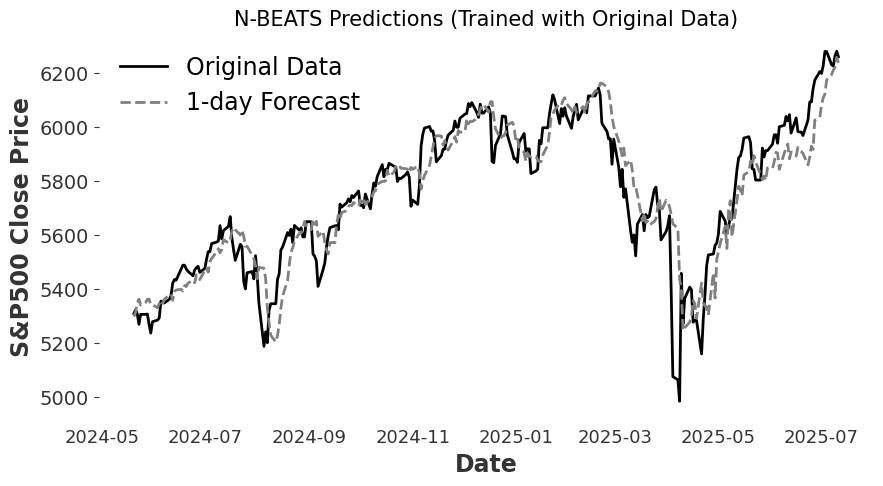

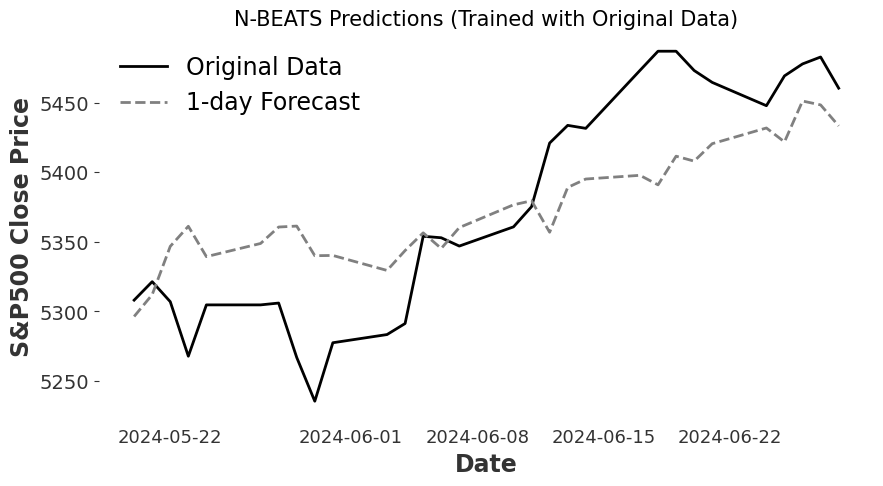


Directional Movement Metrics:

N-BEATS (Original) | Train Accuracy: 50.22%
N-BEATS (Original) | Validation Accuracy: 52.83%
N-BEATS (Original) | Test Accuracy: 45.15%
N-BEATS (Original) | Recall: 51.22%
N-BEATS (Original) | Precision (Rise): 50.00%
N-BEATS (Original) | Precision (Fall): 38.93%
N-BEATS (Original) | F1 Score: 50.60%


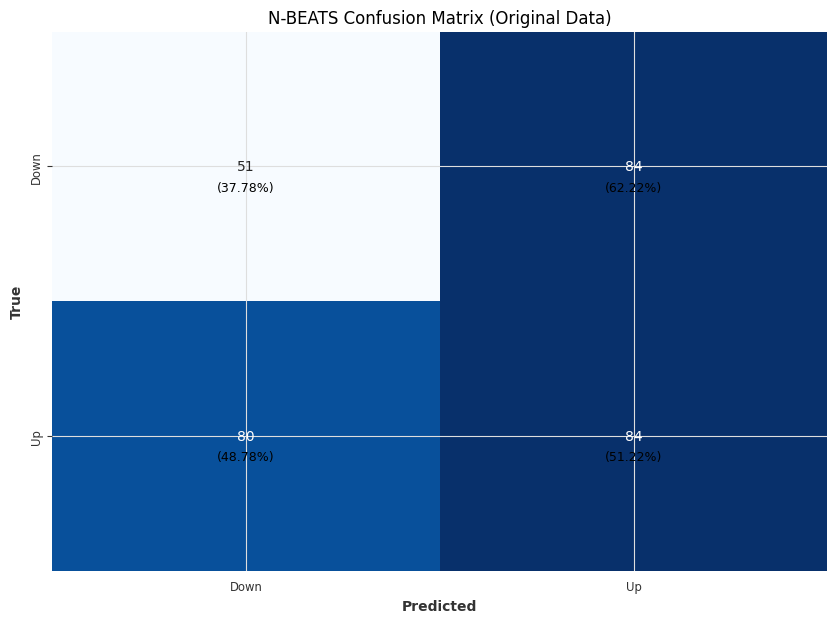

{'MAE': 78.96144490419385, 'MSE': 11761.249245329522, 'RMSE': 108.44929342936966, 'RMSSE': np.float64(1.7058345869279024), 'MAPE': 1.3932501669732125, 'MASE': 1.9324714746597935, 'R2': 0.8437760558652394, 'Test Accuracy': 45.1505016722408, 'Recall': 51.21951219512195, 'Precision (Rise)': 50.0, 'Precision (Fall)': 38.93129770992366, 'F1 Score': 50.602409638554214, 'Validation Accuracy': 52.83018867924528, 'Train Accuracy': 50.22156573116692}


In [ ]:
series = TimeSeries.from_dataframe(df, time_col='Date', value_cols='Close')
series_denoised = TimeSeries.from_dataframe(df, time_col='Date', value_cols ='Close_denoised' )

# 3. Split
train, val, test = split_train_val_test_darts(series, "2023-01-01", "2024-01-01")
train_denoised, val_denoised, test_denoised = split_train_val_test_darts(series_denoised, "2023-01-01", "2024-01-01")

# Normalize
train, val, test, scaler = normalise_split_data_darts(train, val, test)
train_denoised, val_denoised, test_denoised, scaler_denoised = normalise_split_data_darts(train_denoised, val_denoised, test_denoised)

# Model nbeats
model = get_model_nbeats()

# training
metrics = training_darts(
    model,
    train, val, test,
    scaler,
    stock="S&P500",
    data_type="Original",
    train_denoised=train_denoised,
    val_denoised=val_denoised,
    test_denoised=test_denoised,
    scaler_denoised=scaler_denoised
)

print(metrics)